# 模型选择、欠拟合和过拟合

通过多项式拟合来探索这些概念

In [1]:
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

使用以下三阶多项式来生成训练和测试数据的标签：
$$y = 5 + 1.2x - 3.4\frac{x^2}{2!} + 5.6 \frac{x^3}{3!} + \epsilon \text{ where }
\epsilon \sim \mathcal{N}(0, 0.1^2)$$

In [2]:
max_degree = 20
n_train, n_test = 100, 100
true_w = np.zeros(max_degree)
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)

查看一下前2个样本

In [4]:
true_w, features, poly_features, labels = [torch.tensor(x, dtype=
    torch.float32) for x in [true_w, features, poly_features, labels]]

features[:2], poly_features[:2, :], labels[:2]

(tensor([[-0.4999],
         [-0.4965]]),
 tensor([[ 1.0000e+00, -4.9985e-01,  1.2493e-01, -2.0815e-02,  2.6011e-03,
          -2.6004e-04,  2.1663e-05, -1.5469e-06,  9.6655e-08, -5.3682e-09,
           2.6833e-10, -1.2193e-11,  5.0790e-13, -1.9529e-14,  6.9726e-16,
          -2.3235e-17,  7.2589e-19, -2.1343e-20,  5.9270e-22, -1.5593e-23],
         [ 1.0000e+00, -4.9655e-01,  1.2328e-01, -2.0405e-02,  2.5329e-03,
          -2.5154e-04,  2.0817e-05, -1.4767e-06,  9.1654e-08, -5.0567e-09,
           2.5109e-10, -1.1334e-11,  4.6900e-13, -1.7914e-14,  6.3536e-16,
          -2.1032e-17,  6.5272e-19, -1.9065e-20,  5.2592e-22, -1.3744e-23]]),
 tensor([3.8694, 3.9675]))

实现一个函数来评估模型在给定数据集上的损失

In [5]:
def evaluate_loss(net, data_iter, loss):  
    """评估给定数据集上模型的损失"""
    metric = d2l.Accumulator(2)
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

定义训练函数

In [6]:
def train(train_features, test_features, train_labels, test_labels,
          num_epochs=400):
    loss = nn.MSELoss(reduction='none')
    input_shape = train_features.shape[-1]
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1,1)),
                                batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1,1)),
                               batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss),
                                     evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.numpy())

三阶多项式函数拟合(正常)

weight: [[ 5.019018   1.1946101 -3.4238737  5.6215625]]


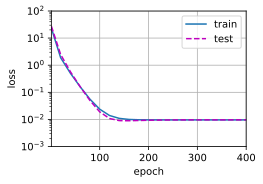

In [7]:
train(poly_features[:n_train, :4], poly_features[n_train:, :4],
      labels[:n_train], labels[n_train:])

线性函数拟合(欠拟合)

weight: [[3.643353  3.9591959]]


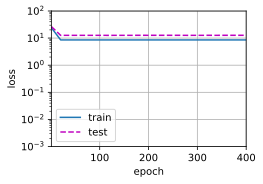

In [8]:
train(poly_features[:n_train, :2], poly_features[n_train:, :2],
      labels[:n_train], labels[n_train:])

高阶多项式函数拟合(过拟合)

weight: [[ 4.98981619e+00  1.28851151e+00 -3.28302407e+00  5.15355873e+00
  -3.46124321e-01  1.13549972e+00  5.10900607e-03  1.18201613e-01
  -1.63049936e-01 -1.38878882e-01  2.88553052e-02 -1.50383292e-02
  -1.69221520e-01 -1.03751056e-01  8.86610001e-02  5.50406016e-02
  -1.06619544e-01  3.09333988e-02  1.18263520e-01 -1.75979659e-01]]


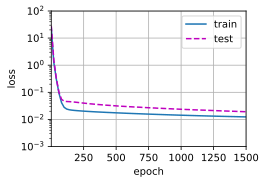

In [9]:
train(poly_features[:n_train, :], poly_features[n_train:, :],
      labels[:n_train], labels[n_train:], num_epochs=1500)